# Resnet50 with XAI

## 1. Import

In [1]:
pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
import numpy as np

import cv2 as cv
import os

2024-05-04 02:41:35.260651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 02:41:35.260705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 02:41:35.262223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load Images

In [3]:
def preprocess_image(image):
    # Preprocess image
    if len(image.shape) == 3: 
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_equalized = cv.equalizeHist(image)
    image_blurred = cv.GaussianBlur(image_equalized, (5, 5), 0)
    _, image_thresh = cv.threshold(image_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    return image_thresh

def load_and_sharpen_images_from_subdirectories(parent_directory, subdirectories, target_size=(224, 224), augment=False):
    images = []
    labels = []  # Store corresponding labels
    for subdir in subdirectories:
        subdir_path = os.path.join(parent_directory, subdir)
        files = os.listdir(subdir_path)
        for file in files:
            image_path = os.path.join(subdir_path, file)
            if os.path.isfile(image_path):
                # Read image
                image = cv.imread(image_path)

                if image is not None:
                    # Preprocess image
                    image_processed = preprocess_image(image)
                    image_rgb = cv.cvtColor(image_processed, cv.COLOR_GRAY2RGB)
                    image_resized = cv.resize(image_rgb, target_size)

                    images.append(image_resized)

                    # Assign label based on directory name
                    if subdir == 'nonvm':
                        labels.append([1, 0])  
                    else:
                        labels.append([0, 1])  

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Data augmentation
    if augment:
        image_gen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            brightness_range=[0.8, 1.0]
        )

        image_gen.fit(images)  # Fit the generator on the training images

        augmented_images = []
        augmented_labels = []

        for x_batch, y_batch in image_gen.flow(images, labels, batch_size=len(images)):
            augmented_images.extend(x_batch)
            augmented_labels.extend(y_batch)
            break

        images = np.array(augmented_images)
        labels = np.array(augmented_labels)

    return images, labels


In [5]:
train_dir = "/kaggle/input/vm-7-2-1-split/Final/train_set"
valid_dir = "/kaggle/input/vm-7-2-1-split/Final/validation_set"
test_dir = "/kaggle/input/vm-7-2-1-split/Final/test_set"

subdirectories = ['vm', 'nonvm']

In [6]:
train_images,train_labels = load_and_sharpen_images_from_subdirectories(train_dir, subdirectories)
valid_images,valied_labels = load_and_sharpen_images_from_subdirectories(valid_dir, subdirectories)
test_images,test_labels = load_and_sharpen_images_from_subdirectories(test_dir,  subdirectories)

In [7]:
print("Number of loaded train images:", len(train_images))
print("Number of loaded test images:", len(test_images))
print("Number of loaded valid images:", len(valid_images))

Number of loaded train images: 87
Number of loaded test images: 26
Number of loaded valid images: 12


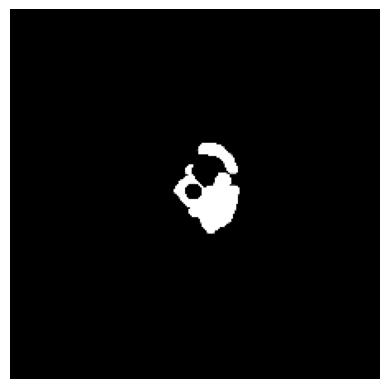

(224, 224, 3)

In [8]:
plt.imshow(train_images[10])  # Show the first image, change the index for different images
plt.axis('off')  # Hide the axes
plt.show()
train_images[10].shape

## 3. Build and train model

In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)  # Replace the final layer with a Dense layer having 2 output classes (for binary classification)

model = Model(inputs=base_model.input, outputs=x)

for layer in model.layers[:-1]:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [11]:
epochs = 25

history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    validation_data=(valid_images, valied_labels)
)

Epoch 1/25
1/3 [=========>....................] - ETA: 13s - loss: 0.6037 - accuracy: 0.7500

I0000 00:00:1714790515.416407   31759 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 11s 2s/step - loss: 0.6821 - accuracy: 0.6667 - val_loss: 0.4202 - val_accuracy: 0.8333
Epoch 2/25
3/3 [==============================] - 0s 117ms/step - loss: 0.4345 - accuracy: 0.8276 - val_loss: 0.3799 - val_accuracy: 0.9167
Epoch 3/25
3/3 [==============================] - 0s 116ms/step - loss: 0.3056 - accuracy: 0.8851 - val_loss: 0.2936 - val_accuracy: 0.9167
Epoch 4/25
3/3 [==============================] - 0s 120ms/step - loss: 0.2360 - accuracy: 0.9195 - val_loss: 0.2934 - val_accuracy: 0.9167
Epoch 5/25
3/3 [==============================] - 0s 115ms/step - loss: 0.2144 - accuracy: 0.9080 - val_loss: 0.2776 - val_accuracy: 0.9167
Epoch 6/25
3/3 [==============================] - 0s 117ms/step - loss: 0.1776 - accuracy: 0.9425 - val_loss: 0.2817 - val_accuracy: 0.9167
Epoch 7/25
3/3 [==============================] - 0s 117ms/step - loss: 0.1528 - accuracy: 0.9425 - val_loss: 0.2858 - val_accuracy: 0.9167
Epoch 8/25
3/3 [=================

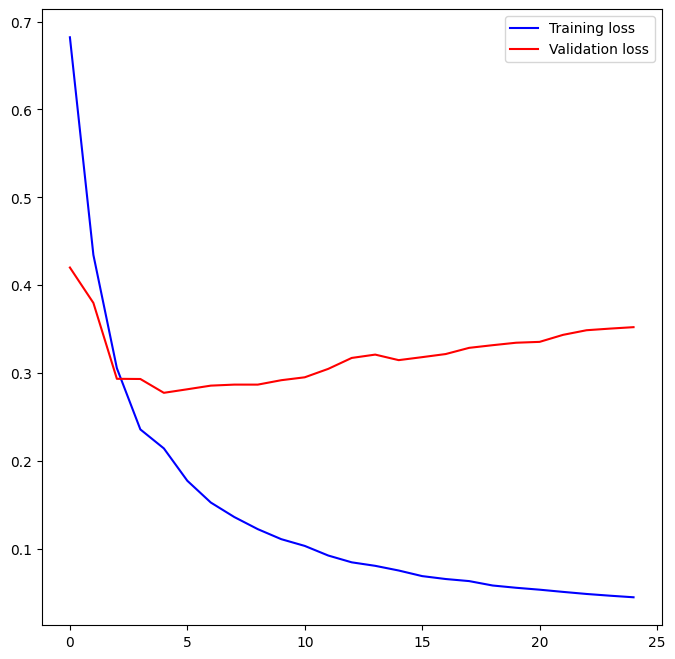

<Figure size 640x480 with 0 Axes>

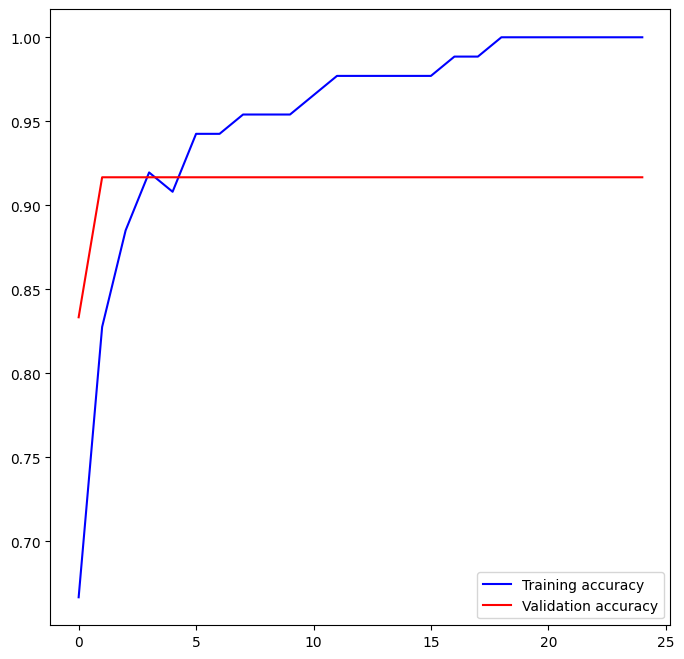

In [12]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend(loc = "lower right")
plt.show()

In [13]:
history.history['accuracy']

[0.6666666865348816,
 0.8275862336158752,
 0.8850574493408203,
 0.9195402264595032,
 0.9080459475517273,
 0.9425287246704102,
 0.9425287246704102,
 0.954023003578186,
 0.954023003578186,
 0.954023003578186,
 0.9655172228813171,
 0.977011501789093,
 0.977011501789093,
 0.977011501789093,
 0.977011501789093,
 0.977011501789093,
 0.9885057210922241,
 0.9885057210922241,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [14]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1/1 [==============================] - 2s 2s/step - loss: 0.2164 - accuracy: 0.9231
Test Loss: 0.21639420092105865
Test Accuracy: 0.9230769276618958


## 4. Apply gradcam

In [15]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])


    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()


In [16]:
def plot_gradcam(img_arrays, heatmap, image_id, model, alpha=0.4):
    # Predict the output class using the model
    prediction = model.predict(np.expand_dims(img_arrays[image_id], axis=0))
    predicted_class = np.argmax(prediction)

    # If predicted class is 0, just show the original image without superimposing the heatmap
    if predicted_class == 0:
        plt.imshow(img_arrays[image_id])
        plt.title('Non VM case')
        plt.axis('off')
        plt.show()
    else:
        # Superimpose the heatmap on the image
        heatmap = np.uint8(255 * heatmap)
        jet = plt.get_cmap("jet")
        heatmap = jet(heatmap)

        heatmap = image.array_to_img(heatmap)
        heatmap = heatmap.resize((img_arrays[image_id].shape[1], img_arrays[image_id].shape[0]))
        heatmap = image.img_to_array(heatmap)

        superimposed_img = heatmap[..., :3] * alpha + img_arrays[image_id]
        superimposed_img = image.array_to_img(superimposed_img)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        plt.suptitle("VM Detected")

        axes[0].imshow(img_arrays[image_id])
        axes[0].set_title('Original')
        axes[0].axis('off')

        # Plot the superimposed image with heatmap in the second subplot
        axes[1].imshow(superimposed_img)
        axes[1].set_title('Grad-CAM')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Replace 'conv5_block3_out' with your desired layer name
last_conv_layer_name = 'conv5_block3_out'


1/1 [==============================] - 2s 2s/step


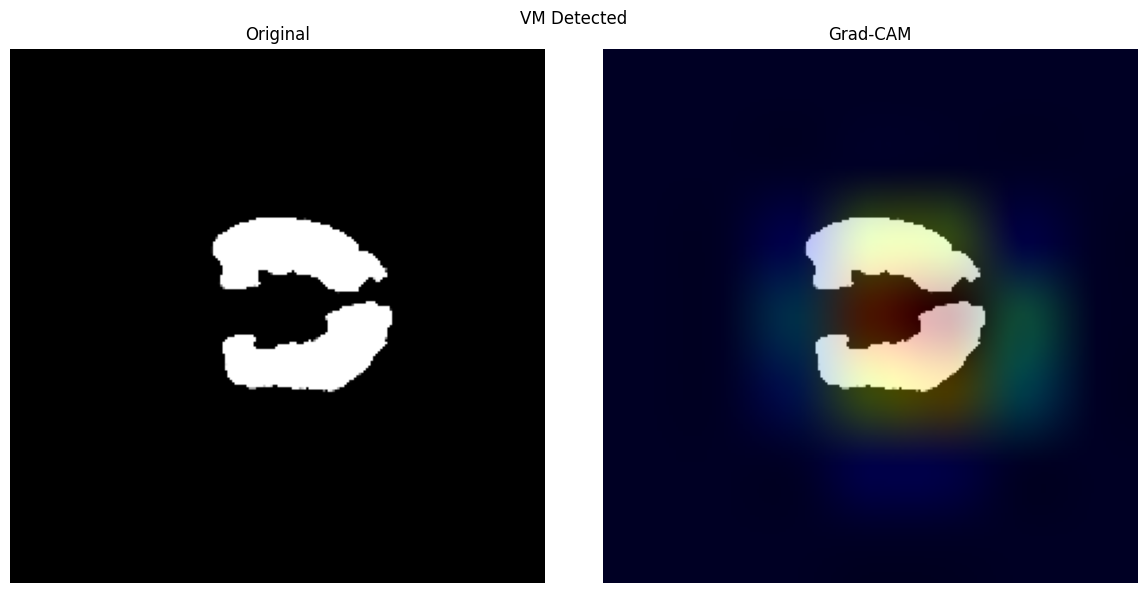

In [17]:
# Generate the heatmap
img_for_heatmap = np.expand_dims(train_images[7], axis=0)  
heatmap = make_gradcam_heatmap(img_for_heatmap, model, last_conv_layer_name)

# Plot Grad-CAM or original image based on predicted class
plot_gradcam(train_images, heatmap, 7, model)

1/1 [==============================] - 0s 25ms/step


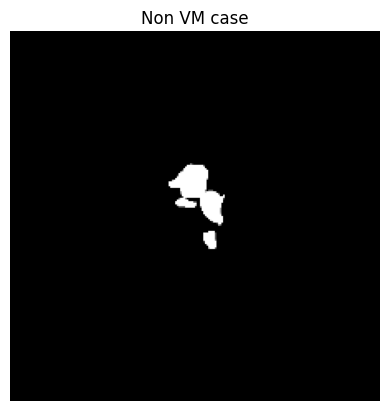

In [18]:
# Generate the heatmap
img_for_heatmap = np.expand_dims(train_images[83], axis=0)  
heatmap = make_gradcam_heatmap(img_for_heatmap, model, last_conv_layer_name)

# Plot Grad-CAM or original image based on predicted class
plot_gradcam(train_images, heatmap, 83, model)

## 5. Apply LIME

In [19]:
pip install lime


Note: you may need to restart the kernel to use updated packages.


In [20]:
import lime
from lime import lime_image
import matplotlib.pyplot as plt
import numpy as np

def apply_lime(img_arrays, image_id, model):
    explainer = lime_image.LimeImageExplainer()

    # Predict the output class using the model
    prediction = model.predict(np.expand_dims(img_arrays[image_id], axis=0))
    predicted_class = np.argmax(prediction)

    # If predicted class is 0, just show the original image
    if predicted_class == 0:
        plt.imshow(img_arrays[image_id])
        plt.title('NonVM')
        plt.axis('off')
        plt.show()
    else:
        # Explain the prediction using LIME
        explanation = explainer.explain_instance(img_arrays[image_id], model.predict, top_labels=1, hide_color=0, num_samples=100)

        # Get the explanation mask
        temp, mask = explanation.get_image_and_mask(predicted_class, positive_only=True, num_features=5, hide_rest=False)
        # Overlay the explanation mask on the image
        plt.imshow(explanation.image)
        plt.imshow(mask, cmap='viridis', alpha=0.6)  # Adjust alpha for transparency
        plt.title('VM Case')
        plt.axis('off')
        plt.show()




1/1 [==============================] - 0s 25ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


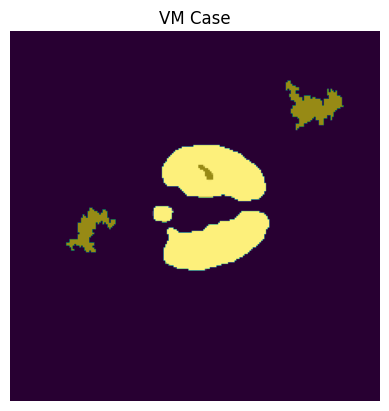

In [21]:
# Apply LIME for the same image
apply_lime(train_images, 14, model)

1/1 [==============================] - 0s 26ms/step


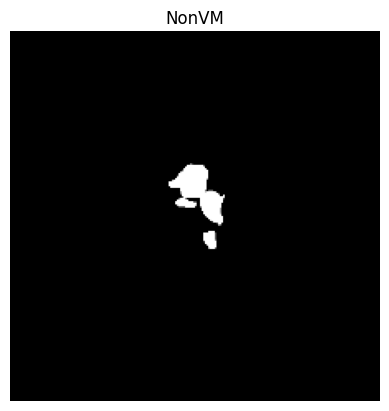

In [22]:
# Apply LIME for the same image
apply_lime(train_images, 83, model)

## Apply SHAP

In [23]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
import numpy as np
from PIL import Image
from keras.applications.resnet50 import preprocess_input

image_dir = "/kaggle/input/vm-7-2-1-split/Final/train_set/vm"

# List to store images and labels
images = []
labels = []

# Iterate over the images in the directory
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Load the image
        img = Image.open(os.path.join(image_dir, filename))
        # Preprocess the image (resize, convert to array, and apply preprocessing)
        img = img.resize((224, 224))  # Resize the image if needed
        img_array = np.array(img)
        img_array = preprocess_input(img_array)
        # Append the preprocessed image to the list of images
        images.append(img_array)
        # Extract the label from the filename (you'll need to customize this based on your filename format)
        label = filename.split("_")[0]  # Assuming the label is the first part of the filename before underscore
        labels.append(label)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Print the shape of the arrays
print("Shape of X (images):", X.shape)
print("Shape of y (labels):", y.shape)

Shape of X (images): (36, 224, 224, 3)
Shape of y (labels): (36,)


In [25]:
import shap

# Define a function to preprocess the input image and pass it through the model
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# Define the masker
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# Create the explainer
explainer_blur = shap.Explainer(f, masker_blur)

# Explain the SHAP values for the images
shap_values_fine = explainer_blur(
    X[1:6], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2]  # Changed to 2 classes
)


  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [00:19<00:06,  3.32s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [00:26<00:04,  4.69s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [00:32<00:00,  5.32s/it]

  0%|          | 0/998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [00:39,  7.82s/it]                       


In [26]:
print(shap_values_fine.shape)

(5, 224, 224, 3, 2)


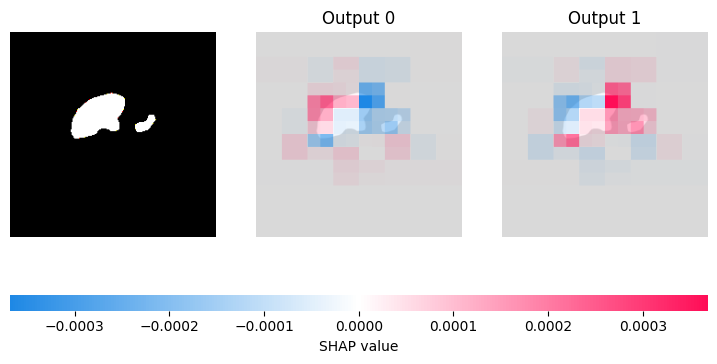

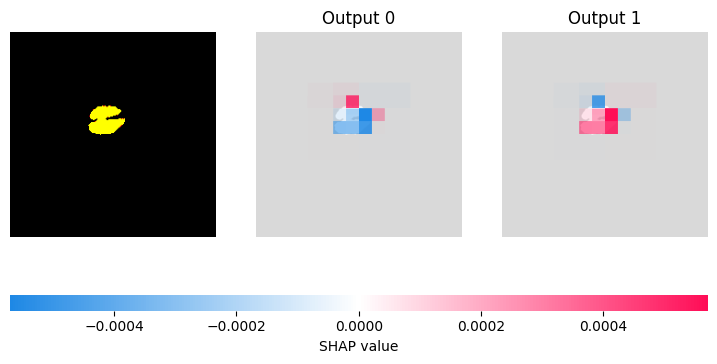

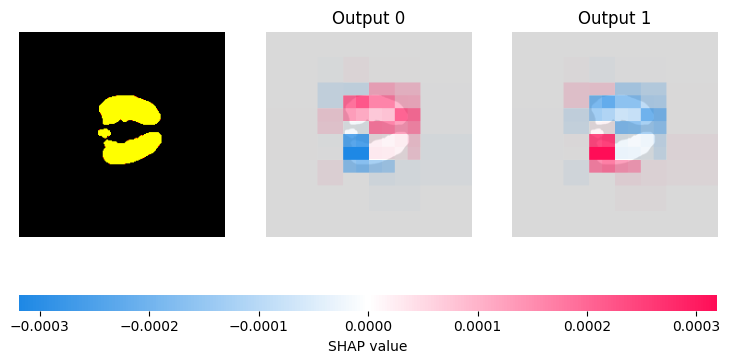

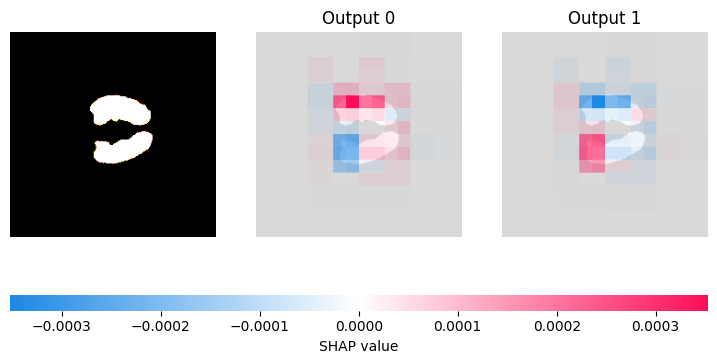

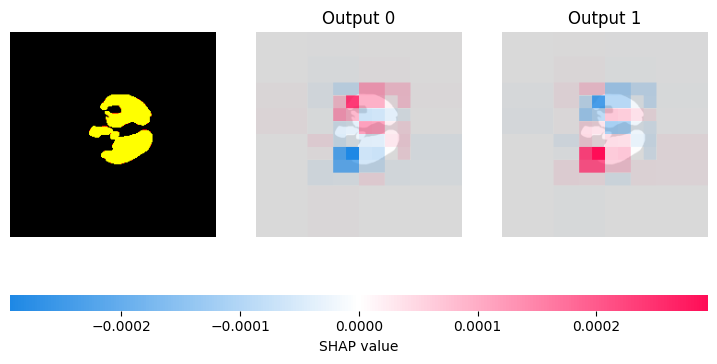

In [27]:
# Plot SHAP values for the first image and the first output class
for i in range(shap_values_fine.shape[0]):
        # Plot SHAP values for the current sample and output class
        shap.image_plot(shap_values_fine[i])